## Validating a recording with RIGOR criteria

In [5]:
import one.alf.io as alfio
import matplotlib.pyplot as plt
from pathlib import Path
from ibllib.ephys.ephysqc import phy_model_from_ks2_path, spike_sorting_metrics_ks2
from phylib.io.alf import EphysAlfCreator
from ibllib.pipes.ephys_tasks import SpikeSorting
import numpy as np
from matplotlib import gridspec
from brainbox.processing import bincount2D, compute_cluster_average
from neuropixel import NP2Converter
import spikeglx
from ibldsp import voltage, utils
import scipy
import pandas as pd
import neuropixel

We need paths to both the raw ephys recording and the spikesorting output (in PHY format).

In [6]:
raw_data_path = Path("/Users/chris/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS046/2020-12-03/001/raw_ephys_data/probe00")
spikesorting_path = Path("/Users/chris/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS046/2020-12-03/001/spike_sorters/pykilosort/probe00/_kilosort_raw.output")

Some helper functions to accomodate NP1 or NP2 data.

In [7]:
def get_probe_geometry(sr):
    th = sr.geometry
    if sr.meta.get('NP2.4_shank', None) is not None:
        h = neuropixel.trace_header(sr.major_version, nshank=4)
        h = neuropixel.split_trace_header(h, shank=int(sr.meta.get('NP2.4_shank')))
    else:
        h = neuropixel.trace_header(sr.major_version, nshank=np.unique(th['shank']).size)
    return h

def get_lf_file(raw_data_path):
    lf_file = next(raw_data_path.glob('*lf.*bin'), None)
    if lf_file is None:
        print('Raw lfp data not found, computing LFP data from AP data for 600s snippet')
        conv = NP2Converter(ap_file, compress=False)
        conv.init_params(nsamples=int(600 * conv.sr.fs))
        conv._process_NP21(offset=int(conv.sr.ns / 2), assert_shanks=False)
        lf_file = next(raw_data_path.glob('*lf.*bin'), None)
    
    return lf_file

### Raw data metrics

First, we can confirm whether the data passes the visually assessed RIGOR criteria. To do this, we'll look at some raw data snippets. We apply IBL's destriping procedure to the snippets. This automatically corrects for some artifacts that would otherwise appear to exclude the recording.

In the raw AP band snippets below, we're looking for epileptiform activity, artifacts from the acquisition hardware, severe drift of the probe, and dead or noisy channels.

This recording is 4971.3346s long.


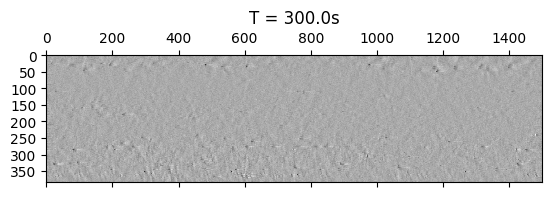

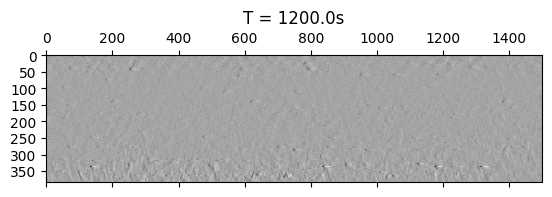

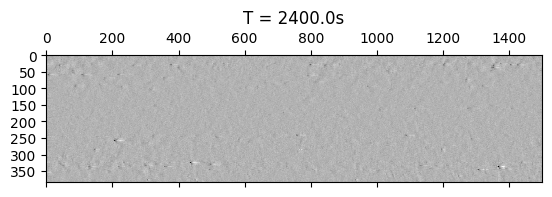

In [8]:
ap_file = next(raw_data_path.glob('*ap.*bin'), None)
sr = spikeglx.Reader(ap_file)
fs = sr.fs
h = get_probe_geometry(sr)

print(f"This recording is {sr.rl}s long.")

# pick some timepoints within the recording
t0s = int(sr.fs) * np.array([300, 1200, 2400])

for i, t0 in enumerate(t0s):
    t0 = t0s[i]
    t1 = t0 + int(0.05 * fs)

    raw = sr[t0:t1, :-sr.nsync].T
    ap_destriped = voltage.destripe(raw, fs=fs, h=h)
    fig, ax = plt.subplots()
    ax.matshow(ap_destriped, cmap="gray")
    ax.set_title(f"T = {t0//fs}s")



Next we will make quantitative assessments of the noise level. The first criterion is that median (across channels) AP RMS < 40 uV.

We'll estimate the RMS channel-wise by computing it on short snippets from throughout the recording. Here we take 1 second snippets every 5 minutes.



In [9]:
nc = sr.nc - sr.nsync

BATCHES_SPACING = 300
TMIN = 40
SAMPLE_LENGTH = 1

t0s = np.arange(TMIN, sr.rl - SAMPLE_LENGTH, BATCHES_SPACING)
all_rms = np.zeros((2, nc, t0s.shape[0]))

for i, t0 in enumerate(t0s):
    sl = slice(int(t0 * sr.fs), int((t0 + SAMPLE_LENGTH) * sr.fs))
    raw = sr[sl, :-sr.nsync].T
    destripe = voltage.destripe(raw, fs=sr.fs, h=h)
    all_rms[0, :, i] = utils.rms(raw)
    all_rms[1, :, i] = utils.rms(destripe)

We computed the RMS for both the raw and destriped data. Let's see how they compare.

/var/folders/hh/pfc8s7xs36z9r45d05bv8nw80000gn/T/ipykernel_74104/3680621212.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(t0s.astype(int))


Text(0.5, 1.0, 'AP RMS')

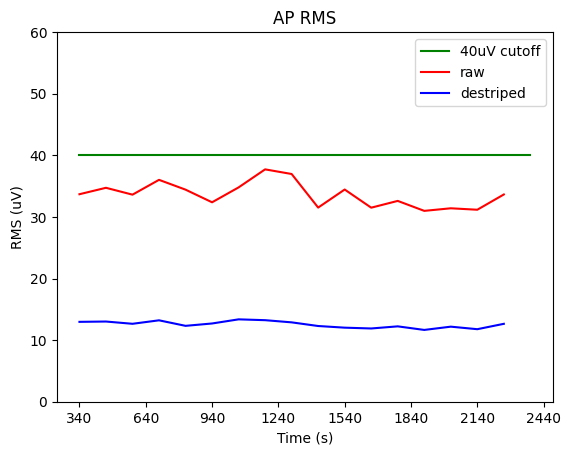

In [10]:
fig, ax = plt.subplots()
n_snippets = all_rms.shape[-1]

raw_rms_median = np.median(all_rms[0, :, :], axis=0)
des_rms_median = np.median(all_rms[1, :, :], axis=0)

ax.plot([0, n_snippets], [40, 40], "g", label="40uV cutoff")
ax.plot(raw_rms_median * 1e6, "r", label="raw")
ax.plot(des_rms_median * 1e6, "b", label="destriped")
ax.set_ylim(0, 60)
ax.set_ylabel("RMS (uV)")
ax.set_xticklabels(t0s.astype(int))
ax.set_xlabel("Time (s)")
ax.legend()
ax.set_title("AP RMS")

Above we can see that the RMS consistently stays below the threshold for the duration of the recording. The destriping removes certain low frequency artifacts in the time domain, leading to a lower RMS. 

In [11]:
passing_ap_rms = np.all(raw_rms_median < 40*1e-6)
print(f"Passing AP rms: {passing_ap_rms}")

Passing AP rms: True


The next computed metric pertains to the LFP band. The spatial derivative of the LFP power spectrum should be < 1. Again we use destriped snippets from across the recording to estimate the power spectrum, and then estimate its spatial derivative.

In [12]:
# load the LFP data
lf_file = get_lf_file(raw_data_path)
sr = spikeglx.Reader(lf_file)
h = get_probe_geometry(sr)

LFP_RESAMPLE_FACTOR = 10
LFP_BAND = [20, 80]

BATCHES_SPACING = 200
TMIN = 40
SAMPLE_LENGTH = 20

t0s = np.arange(TMIN, sr.rl - SAMPLE_LENGTH, BATCHES_SPACING)

for j, t0 in enumerate(t0s):
    sl = slice(int(t0 * sr.fs), int((t0 + SAMPLE_LENGTH) * sr.fs))
    raw = sr[sl, :-sr.nsync].T
    destripe = voltage.destripe_lfp(raw, fs=sr.fs, h=h, channel_labels=True)
    lfp = scipy.signal.decimate(destripe, LFP_RESAMPLE_FACTOR, axis=1, ftype='fir')

    f, pow = scipy.signal.periodogram(lfp, fs=250, scaling='density')
    if j == 0:
        rms_lf_band = np.zeros((lfp.shape[0], len(t0s)))

    rms_lf_band[:, j] = np.nanmean(
            10 * np.log10(pow[:, np.logical_and(f >= LFP_BAND[0], f <= LFP_BAND[1])]), axis=-1)
    lfp_power = np.nanmedian(rms_lf_band - 20 * np.log10(f[1]), axis=-1) * 2


Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults
/Users/chris/Documents/PYTHON/int-brain-lab/ibl-neuropixel/src/ibldsp/voltage.py:308: RuntimeWarning: invalid value encountered in divide
  weights = weights / gp.sum(weights)


We are interested in how smoothly the LFP power varies over channels. While there are a handful of sharp spatial gradients, we can see that as a whole the value is smoothly varying for this recording.

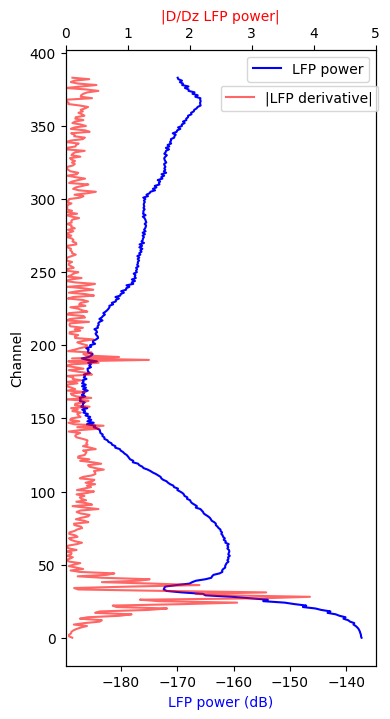

In [13]:
fig, ax = plt.subplots(figsize=(4, 8))
ax.plot(lfp_power, np.arange(384), c="b", label="LFP power")
ax.set_ylabel("Channel")
ax.set_xlabel("LFP power (dB)", color="blue")
ax.legend()

ax2 = ax.twiny()
ax2.plot(np.abs(np.gradient(lfp_power)), np.arange(384), c="r", label="|LFP derivative|", alpha=0.6)
ax2.set_xlim(0, 5)
ax2.set_xlabel("|D/Dz LFP power|", color="red")
ax2.legend(loc=(.5,.9))

Indeed if we compute the median, we see that it's <1 and thus satisfies the criterion.

In [14]:
lfp_deriv = np.median(np.abs(np.gradient(lfp_power)))
lfp_passing = lfp_deriv < 1
print(f"Median LFP power derivative: {lfp_deriv}")
print(f"Passing: {lfp_passing}")


Median LFP power derivative: 0.18691789882998933
Passing: True


### Spike sorting metrics

Now we turn to the RIGOR criteria pertaining to the quality of the spike sorting run. First, we convert the PHY spike sorting output to the IBL's [ALF format](https://int-brain-lab.github.io/ONE/alf_intro.html) to compute IBL metrics. 

In [15]:
# pick a location to store the ALF files
save_path = Path("/Users/chris/Documents/ALF_example")

m = phy_model_from_ks2_path(ks2_path=spikesorting_path, bin_path=raw_data_path)
ac = EphysAlfCreator(m)
ac.convert(save_path, label=None, force=True, ampfactor=SpikeSorting._sample2v(ap_file))

m.depths = np.load(save_path.joinpath('spikes.depths.npy'))
c = spike_sorting_metrics_ks2(ks2_path=spikesorting_path, m=m)
c.to_parquet(Path(save_path).joinpath('clusters.metrics.pqt'))

# load sorting information
channels = alfio.load_object(save_path, 'channels')
clusters = alfio.load_object(save_path, 'clusters')
spikes = alfio.load_object(save_path, 'spikes')

/Users/chris/miniconda3/envs/iblenv/lib/python3.10/site-packages/phylib/io/model.py:1090: RuntimeWarning: invalid value encountered in divide
  spikes_depths[ispi] = (np.sum(np.transpose(ypos * features) /
Extracting waveforms: 100%|██████████| 4971.3346/4971.3346 [00:08<00:00, 589.12it/s]
Converting to ALF: 155it [00:45,  3.40it/s]                         


The simplest whole recording spike sorting metric is the yield, i.e. the number of passing units recovered per channel site. We can get this from the pre-computed IBL metrics table.

In [16]:
neuron_yield = (clusters.metrics.label == 1).sum() / len(channels.localCoordinates)
yield_passing = neuron_yield > 0.1
print(f"Yield: {neuron_yield} passing units/site")
print(f"Passing: {yield_passing}")

Yield: 0.2942708333333333 passing units/site
Passing: True


### Single unit metrics

We computed the IBL metrics above to determine the yield of the recording. Now we can take a look at the individual single-unit metrics.

The sliding refractory period violations metrics is computed as a binary pass or fail, while the amplitude median must be > 50uV, and the noise cutoff metric < 5. See the [IBL's spike sorting whitepaper](https://figshare.com/articles/online_resource/Spike_sorting_pipeline_for_the_International_Brain_Laboratory/19705522?file=49783080) for an in-depth discussion of the single unit metrics.

In [22]:
cols = ["slidingRP_viol", "amp_median", "noise_cutoff"]
clusters.metrics[cols]

,slidingRP_viol,amp_median,noise_cutoff
cluster_id,,,
0,1.0,18.568810,1.498651
1,1.0,17.328212,9.605875
2,1.0,11.236026,112.271645
3,1.0,11.262484,86.885517
4,0.0,12.093415,20.788046
...,...,...,...
903,0.0,14.048809,-0.561449
904,0.0,13.162925,21.809524
905,0.0,18.023600,-1.264911


In [23]:
num_units = len(clusters.metrics)
passing_srp = sum(clusters.metrics["slidingRP_viol"] == 1) / num_units
passing_amp = sum(clusters.metrics["amp_median"] > 50) / num_units
passing_nc = sum(clusters.metrics["noise_cutoff"] < 5) / num_units
passing_all = sum(clusters.metrics["label"] == 1) / num_units

print(f"{100*passing_srp} % passing sliding refractory period violation")
print(f"{100*passing_amp} % passing amplitude median")
print(f"{100*passing_nc} % passing noise cutoff")
print(f"{100*passing_all} % passing all")


31.828193832599116 % passing sliding refractory period violation
0.4405286343612335 % passing amplitude median
39.4273127753304 % passing noise cutoff
12.444933920704845 % passing all


### Plot summary

(0.0, 1.0, 0.0, 1.0)

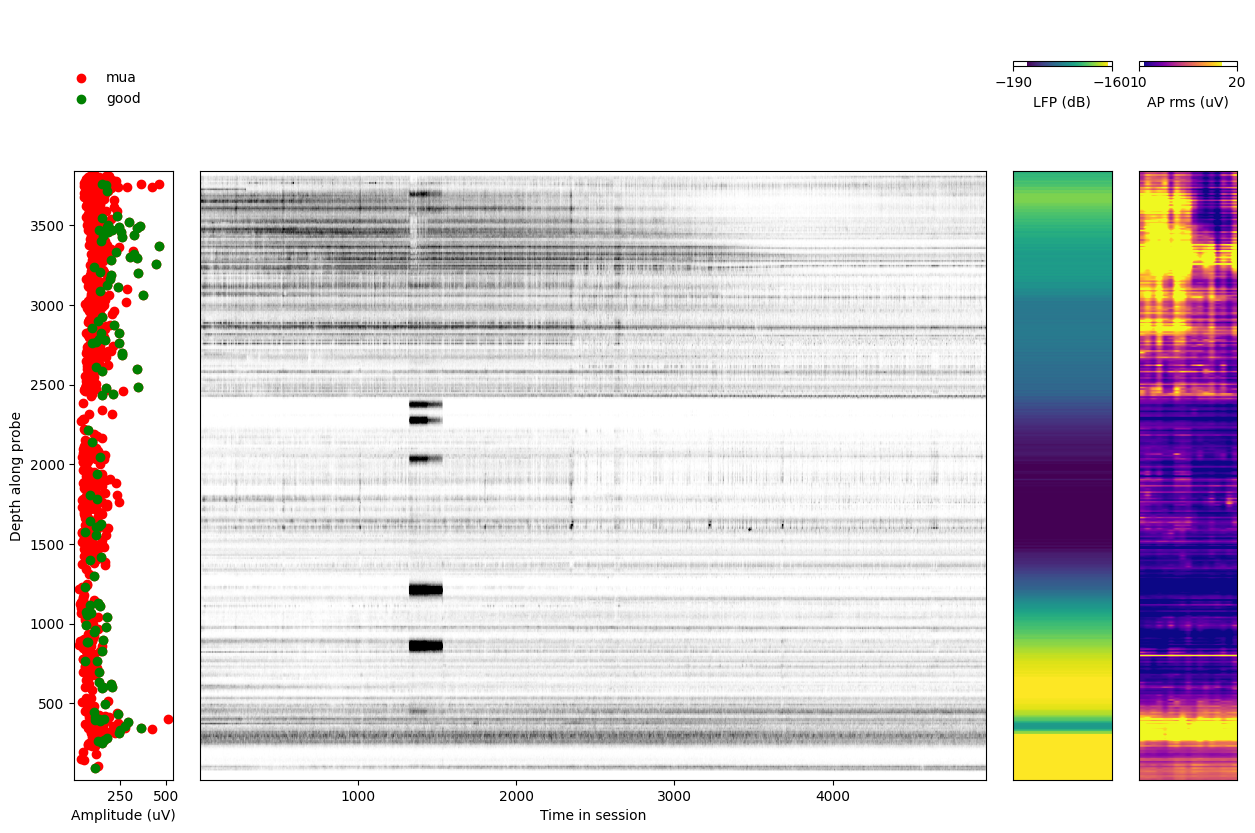

In [29]:
fig = plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(1, 1, figure=fig, wspace=0.3, hspace=0.3)
gs0 = gridspec.GridSpecFromSubplotSpec(2, 4, subplot_spec=gs[0], width_ratios=[1, 8, 1, 1],
                                        height_ratios=[1, 10], wspace=0.1, hspace=0.3)
gs0_ax1 = fig.add_subplot(gs0[0, 0])
gs0_ax2 = fig.add_subplot(gs0[1, 0])
gs0_ax3 = fig.add_subplot(gs0[0, 1])
gs0_ax4 = fig.add_subplot(gs0[1, 1])
gs0_ax5 = fig.add_subplot(gs0[0, 2])
gs0_ax6 = fig.add_subplot(gs0[1, 2])
gs0_ax7 = fig.add_subplot(gs0[0, 3])
gs0_ax8 = fig.add_subplot(gs0[1, 3])

min_chn = np.min(channels.localCoordinates[:, 1])
max_chn = np.max(channels.localCoordinates[:, 1])

# CLUSTER DEPTH VS AMP PLOT
kp_idx = ~np.isnan(spikes.depths)
_, cluster_depth, _ = compute_cluster_average(spikes.clusters[kp_idx], spikes.depths[kp_idx])
_, cluster_amp, _ = compute_cluster_average(spikes.clusters[kp_idx], spikes.amps[kp_idx])
good_idx = np.where(clusters.metrics.label[np.isin(clusters.metrics.cluster_id,
                                                    np.unique(spikes.clusters[kp_idx]))] == 1)
mua = gs0_ax2.scatter(cluster_amp * 1e6, cluster_depth, c='r')
good = gs0_ax2.scatter(cluster_amp[good_idx] * 1e6, cluster_depth[good_idx], c='g')
gs0_ax1.legend(handles=[mua, good], labels=['mua', 'good'], frameon=False, bbox_to_anchor=(0.8, 0.2))
gs0_ax1.axis('off')
gs0_ax2.set_xlabel('Amplitude (uV)')
gs0_ax2.set_ylabel('Depth along probe')
gs0_ax2.set_ylim(min_chn, max_chn)

# SESSION RASTER PLOT
t_bin = 0.1
d_bin = 10
kp_idx = ~np.isnan(spikes.depths)
session_raster, t_vals, d_vals = bincount2D(spikes.times[kp_idx], spikes.depths[kp_idx],
                                            t_bin, d_bin, ylim=[min_chn, max_chn])
session_raster = session_raster / t_bin
gs0_ax4.imshow(session_raster, extent=np.r_[np.min(t_vals), np.max(t_vals), min_chn, max_chn], aspect='auto',
                origin='lower', vmax=50, cmap='binary')
gs0_ax3.axis('off')
gs0_ax4.set_yticks([])
gs0_ax4.set_xlabel('Time in session')

# LFP PLOT
clim = np.nanquantile(lfp_power, [0.1, 0.9])
lf_im = gs0_ax6.imshow(lfp_power[:, np.newaxis], extent=np.r_[0, 10, min_chn, max_chn], origin='lower', cmap='viridis', aspect='auto',
                        vmin=clim[0], vmax=clim[1])
cbar = fig.colorbar(lf_im, orientation="horizontal", ax=gs0_ax5)
cbar.set_label('LFP (dB)')
ticks = cbar.get_ticks()
cbar.set_ticks([ticks[0], ticks[-1]])
gs0_ax5.axis('off')
gs0_ax6.set_yticks([])
gs0_ax6.set_xticks([])

# AP RMS PLOT
rms_vals = all_rms[1, :]* 1e6
clim = np.nanquantile(rms_vals, [0.1, 0.9])
rms_im = gs0_ax8.imshow(rms_vals, extent=np.r_[0, 10, min_chn, max_chn], origin='lower', cmap='plasma', aspect='auto',
                        vmin=clim[0], vmax=clim[1])
gs0_ax8.set_yticks([])
gs0_ax8.set_xticks([])
cbar = fig.colorbar(rms_im, orientation="horizontal", ax=gs0_ax7)
cbar.set_label('AP rms (uV)')
ticks = cbar.get_ticks()
cbar.set_ticks([ticks[0], ticks[-1]])
gs0_ax7.axis('off')

### Save results

This cell saves the raw data metrics to a pandas DataFrame

In [24]:
np.save(save_path.joinpath('_iblqc_ephysChannels.apRMS.npy'), all_rms)

df_lfp = pd.DataFrame.from_dict({"lfp_power": lfp_power, "lfp_derivative": lfp_deriv})
df_lfp.to_parquet(save_path.joinpath('lfp_metrics.pqt'))

In [26]:
channels.rawInd

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18